##### Colab-specific section (convert to code if needed)
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!unlink "/content/coopmotion"
!ln -s "/gdrive/My Drive/coopmotion/" "/content/coopmotion"
!rm -r "/content/coopmotion/dataset (1)" "/content/coopmotion/dataset" "/content/coopmotion/models"

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
sys.path.append('coopmotion/src') # COLAB
from matplotlib import pyplot as plt
from task.fancy import animate_with_targets, plot_trace
import numpy as np
import torch
import time

# Learning

In [53]:
from task.dataset import *
from task.square import *
controller = proportional

In [54]:
task = static_evenly_spread_task(4, holonomic=True)
run = SquareRun(task, controller=controller, sensor=sense(), dt=0.1)

In [55]:
number_of_samples = 100
eps = 0.01
train_dataset = central_dataset(
    generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
test_dataset = central_dataset(
    generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))


x (3728, 8)	y (3728, 8)



x (3767, 8)	y (3767, 8)


# Centralized Network

In [56]:
from keras_network import CentralizedNet
net = CentralizedNet(4, run.task.holonomic)
history = net.train(epochs=100, train_dataset=train_dataset, test_dataset=test_dataset)

mean_squared_error: 0.00
mean_absolute_error: 0.01
mean_squared_error: 0.00
accuracy: 0.70


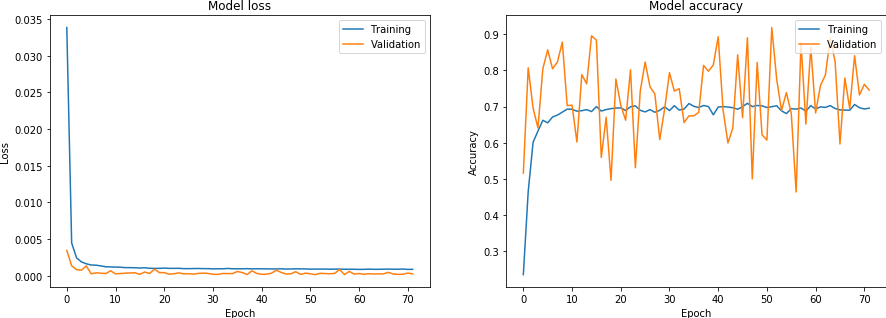

Saved in images/training/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.png


<Figure size 432x288 with 0 Axes>

In [57]:
from task.fancy import training_plot
training_plot(history, context=globals())

Saved in images/trace/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.png


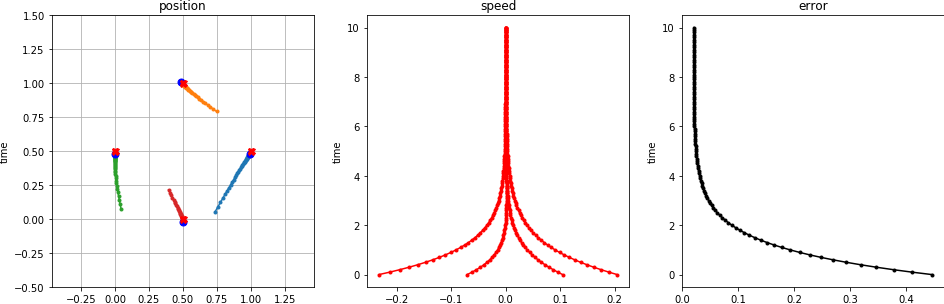

In [58]:
from task import Run
from task.square import sense
net_controller = net.controller()
net_run = Run(task, sensor=run.sensor, dt=0.1, controller=net_controller)
trace = net_run(T=10, epsilon=eps)
plot_trace(trace, task, context=globals())

In [59]:
animate_with_targets(trace, sensor=net_run.sensor, context=globals())

(101, 4, 2)
Saved in videos/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.mp4


### How well are we controlling the agents?

In [60]:
from task.dataset import generate_sequential_dataset
exact_traces = generate_sequential_dataset(run, number=100, duration=10, epsilon=0.01)
net_traces = generate_sequential_dataset(net_run, number=100, duration=10, epsilon=0.01)
from task import prepare
exact_traces = [prepare(t, padding=True, steps=50) for t in exact_traces]
net_traces = [prepare(t, padding=True, steps=50) for t in net_traces]
time = exact_traces[0].time
exact_error = np.array([t.error for t in exact_traces])
net_error = np.array([t.error for t in net_traces])

Saved in images/error/eps=0.01_n=100_net=CentralizedNet_t=holo-StaticPositionTask.png


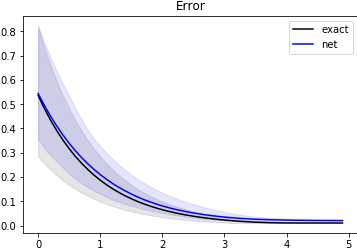

In [61]:
from task.fancy import plot_error
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, context=globals(), color='blue', label='net')

## Distributed Network

In [186]:
from task.square import SquareRun, adaptive_evenly_spread_task, sense
from task.dataset import distributed_dataset

In [187]:
task = adaptive_evenly_spread_task(4, holonomic=True, radius=None)
run = SquareRun(task, controller=controller, sensor=sense(sorted=True), dt=0.1)

In [213]:
number_of_samples = 10000
eps = 0.01
#d_train_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
#d_test_dataset = distributed_dataset(generate_non_sequential_dataset(run=run, number=number_of_samples, epsilon=eps))
d_train_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))
d_test_dataset = distributed_dataset(generate_randomstart_dataset(run=run, number=number_of_samples))

(40000, 6) (40000, 2)


(40000, 6) (40000, 2)


In [214]:
from keras_network import DistributedNet
d_net = DistributedNet(run=run)
history = d_net.train(epochs=10, train_dataset=d_train_dataset, test_dataset=d_test_dataset);

Train on 32000 samples, validate on 8000 samples
Epoch 1/10
32000/32000 [==============================] - 2s 58us/sample - loss: 0.0433 - mean_absolute_error: 0.1687 - mean_squared_error: 0.0433 - acc: 0.6268 - val_loss: 0.0391 - val_mean_absolute_error: 0.1614 - val_mean_squared_error: 0.0391 - val_acc: 0.6957
Epoch 2/10
32000/32000 [==============================] - 1s 43us/sample - loss: 0.0387 - mean_absolute_error: 0.1600 - mean_squared_error: 0.0387 - acc: 0.6874 - val_loss: 0.0388 - val_mean_absolute_error: 0.1608 - val_mean_squared_error: 0.0388 - val_acc: 0.6946
Epoch 3/10
32000/32000 [==============================] - 1s 42us/sample - loss: 0.0373 - mean_absolute_error: 0.1566 - mean_squared_error: 0.0373 - acc: 0.6880 - val_loss: 0.0345 - val_mean_absolute_error: 0.1494 - val_mean_squared_error: 0.0345 - val_acc: 0.7105
Epoch 4/10
32000/32000 [==============================] - 1s 40us/sample - loss: 0.0330 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0330 - acc: 0.

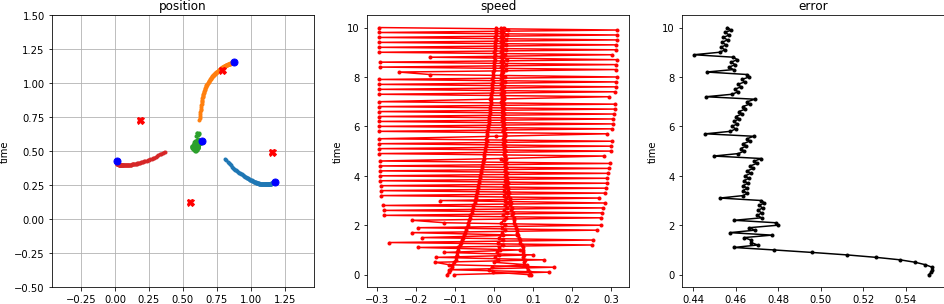

In [219]:
d_net_controller = d_net.controller()
d_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=d_net_controller)
trace = d_net_run(T=10, epsilon=0.01)
plot_trace(trace, task)

In [220]:
animate_with_targets(trace, sensor=net_run.sensor)

(101, 4, 2)


In [217]:
d_net_traces = generate_sequential_dataset(d_net_run, number=100, duration=10, epsilon=0.01)
d_net_traces = [prepare(t, padding=True, steps=50) for t in d_net_traces]
d_net_error = np.array([t.error for t in d_net_traces])

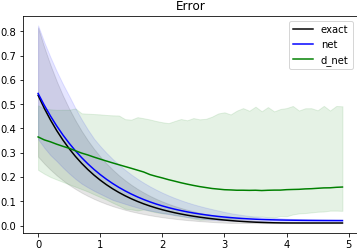

In [218]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plt.legend()
plt.title('Error');

## Distributed Communicating Network

In [333]:
from task.dataset import sequence_dataset
from task.square import adaptive_evenly_spread_task, sense, SquareRun, proportional

In [352]:
task = adaptive_evenly_spread_task(4)
run = SquareRun(task, controller=controller, 
                sensor=sense(sorted=True, range=1.), dt=0.1)
#plot_trace(run(T=0.5),task)

Assuming holonomic robots, otherwise change the task parameter


In [356]:
number_of_samples = 1000
train_traces = generate_sequential_dataset(run=run, number=number_of_samples)
test_traces = generate_sequential_dataset(run=run, number=number_of_samples)

In [357]:
c_train_dataset = sequence_dataset(train_traces, steps=5)
c_test_dataset = sequence_dataset(test_traces, steps=5)

In [358]:
x,y = c_train_dataset[0]
x.shape

torch.Size([5, 4, 3, 3])

In [359]:
from com_network import ComNet
from pytorch_network import train_net

In [360]:
c_net = ComNet(N=4, broadcast=3)
c_training_loss, c_testing_loss = [], []

In [361]:
train_net(epochs=10, net=c_net, train_dataset=c_train_dataset, test_dataset=c_test_dataset, batch_size=100, 
          training_loss=c_training_loss, testing_loss=c_testing_loss);

100%|██████████| 10/10 [01:50<00:00, 11.14s/it]


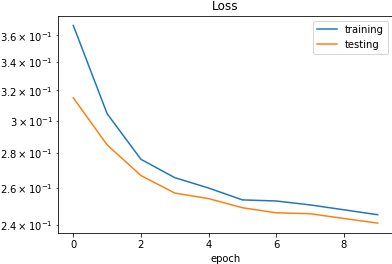

In [362]:
plt.title('Loss')
plt.semilogy(c_training_loss, label='training')
plt.semilogy(c_testing_loss, label='testing')
plt.xlabel('epoch')
plt.legend()

In [363]:
c_net_controller = c_net.controller()
c_net_run = Run(task, sensor=run.sensor, dt=0.1, controller=c_net_controller)

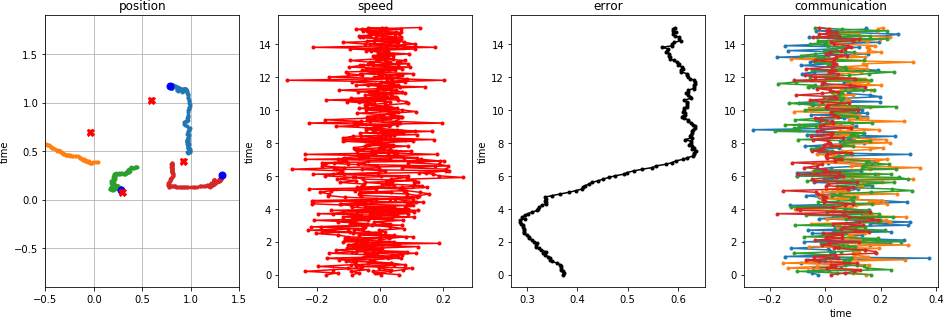

In [364]:
trace = c_net_run(T=15)
plot_trace(trace,task)

In [373]:
animate_with_targets(trace, sensor=c_net_run.sensor)

(151, 4, 2)


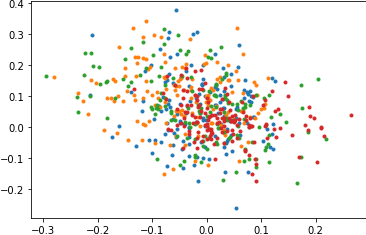

In [366]:
plt.plot(trace.control[:,:,0], trace.communication[:,0,:], '.')

In [367]:
c_net_traces = generate_sequential_dataset(c_net_run, number=100, duration=5, epsilon=0.01)

In [368]:
c_net_traces = [prepare(t, padding=True, steps=50) for t in c_net_traces]

In [369]:
c_net_error = np.array([t.error for t in c_net_traces])

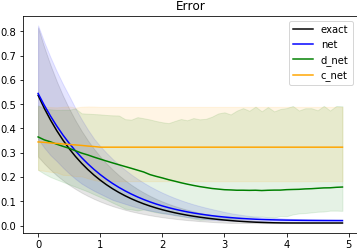

In [370]:
plot_error(time, exact_error, color='black', label='exact')
plot_error(time, net_error, color='blue', label='net')
plot_error(time, d_net_error, color='green', label='d_net')
plot_error(time, c_net_error, color='orange', label='c_net')
plt.legend()
plt.title('Error');